## Task 1: Load theData
Import required libraries and load the three datasets (`sales`, `product`, `customer`) into separate DataFrames using `pandas.read_csv()`.  
This step ensures the data isavailable for cleaning and analysis.

In [207]:
#Import necessary libraries
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Create dataframesfrom CSV files
sales_df = pd.read_csv("sales_data.csv")
product_df = pd.read_csv("product_info.csv")
customer_df = pd.read_csv("customer_info.csv")

#Confirm data loading
print("Data loaded successfully")

Data loaded successfully


## Task 2: Clean the Data

### 2.1 Standardize Text Columns

This function cleansselected text columns in each DataFrame by:
- Stripping whitespace
- Applying `.title()` for categorical values (e.g., `region`, `gender`, `delivery_status`)
- Applying `.lower()` for `email` to preserve format consistency
- Fixing known typos in key columns before merging:
  - `"Brnze"` → `"Bronze"`, `"Sllver"` → `"Silver"`, `"Gld"` → `"Gold"` in `loyalty_tier`
  - `"Delrd"`, `"Delivey"` → `"Delivered"`, `"Delyd"` → `"Delayed"` in `delivery_status`

These steps ensure consistentformatting and prevent fragmented groupings during analysis.  
Only safe, relevant columns are cleaned (e.g., no changes to IDs or dates).  
The script reports how many values were modified in each column.

In [208]:
#Function tostandardize text columns and fix known typos in loyalty_tier
def standardize_text_columns(df, df_name="df"):
    # Columns likely to need standardisation
    allowed_columns = ['delivery_status', 'payment_method', 'region', 'gender', 'loyalty_tier', 'email']
    
    for col in df.select_dtypes(include='object').columns:
        if col not in allowed_columns:
            continue  # Skip irrelevant columns

        original = df[col]

        # Email: lowercase; Others: title case
        if col == 'email':
            cleaned = df[col].astype(str).str.strip().str.lower()
        else:
            cleaned = df[col].astype(str).str.strip().str.title()

        #Apply correction for known typos in loyalty_tier
        if col == 'loyalty_tier':
            typo_corrections = {
                'Brnze': 'Bronze',
                'Gld': 'Gold',
                'Sllver': 'Silver',
                'Nan': 'Unknown',
                'nan': 'Unknown'
            }
            cleaned = cleaned.replace(typo_corrections)

        changed = (original != cleaned).sum()
        df[col] = cleaned
        print(f"Standardised {changed} values in '{col}' ({df_name})")


In [ ]:
# Standardizetext columns in each DataFrame
standardize_text_columns(sales_df, "sales_df")
standardize_text_columns(product_df, "product_df")
standardize_text_columns(customer_df, "customer_df")

Standardised 1781 values in 'delivery_status' (sales_df)
Standardised 1485 values in 'payment_method' (sales_df)
Standardised 1 values in 'region' (sales_df)
Standardised 6 values in 'email' (customer_df)
Standardised 269 values in 'gender' (customer_df)
Standardised 3 values in 'region' (customer_df)
Standardised 382 values in 'loyalty_tier' (customer_df)


In [210]:
#Define known typos in delivery_status and their corrections
delivery_status_corrections = {
    'Delrd': 'Delivered',
    'Delivey': 'Delivered',
    'Delyd': 'Delayed'
}

#Count how many values will be corrected
num_corrections = sales_df['delivery_status'].isin(delivery_status_corrections.keys()).sum()
print(f"Fixed {num_corrections} delivery_status typos")

# Apply the corrections
sales_df['delivery_status'] = sales_df['delivery_status'].replace(delivery_status_corrections)

Fixed 2 delivery_status typos


### 2.2Convert Date Columns

Convert `order_date`, `signup_date`,and `launch_date` to datetime format using `pd.to_datetime()` to enable time-based analysis and feature engineering.

In [212]:
#Convert date columns to datetime using specified format
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'], format="%d-%m-%y", errors='coerce')
product_df['launch_date'] = pd.to_datetime(product_df['launch_date'], format="%d-%m-%y", errors='coerce')
customer_df['signup_date'] = pd.to_datetime(customer_df['signup_date'], format="%d-%m-%y", errors='coerce')

#Display sample dates
display(sales_df[['order_date']].head())
display(product_df[['launch_date']].head())
display(customer_df[['signup_date']].head())

,order_date
0,2025-07-06
1,2025-07-06
2,2025-07-06
3,2025-07-06
4,2025-07-06


,launch_date
0,2025-03-11
1,2024-08-18
2,2024-07-15
3,2025-04-19
4,2024-10-20


,signup_date
0,2025-04-26
1,2024-08-11
2,2025-05-15
3,2025-06-14
4,2025-05-02


### 2.3 Handle Missing Values

Missing values are handled in all three datasets:

- Checked using `.isnull().sum()`
- Filled where appropriate:
  - `discount_applied` → filled with `0.0`
  - `loyalty_tier`, `region` → filled with `"Unknown"`
  - `email` → filled with `"unknown@unknown.com"`
- Rows dropped only when critical fields are missing (e.g., `order_id`,`customer_id`, `product_id`, or `order_date`) to ensure integrity during merges.

Missing values are rechecked after cleaningto confirm completeness.

In [ ]:
#Check missing values in all dataframes
print("Missing values in sales_df:")
display(sales_df.isnull().sum())

print("Missing valuesin customer_df:")
display(customer_df.isnull().sum())

print("Missing values in product_df:")
display(product_df.isnull().sum())

# Fill missing numeric values
sales_df['discount_applied'] = sales_df['discount_applied'].fillna(0.0)

#Fill categorical fields with 'Unknown' where appropriate
customer_df['loyalty_tier'] = customer_df['loyalty_tier'].fillna('Unknown')
customer_df['region'] = customer_df['region'].fillna('Unknown')
customer_df['email'] = customer_df['email'].fillna('unknown@unknown.com')

# Drop rows with missing critical IDs or dates
sales_df = sales_df.dropna(subset=['order_id', 'customer_id', 'product_id', 'order_date'])
customer_df = customer_df.dropna(subset=['customer_id', 'signup_date'])
product_df = product_df.dropna(subset=['product_id', 'product_name']) 

#Drop rows with missing quantity or unit_price (essential for revenue calculation)
sales_df = sales_df.dropna(subset=['quantity', 'unit_price'])

# Recheck missing values after cleaning
print("Remaining missing values in sales_df:")
display(sales_df.isnull().sum())

print("Remaining missing values in customer_df:")
display(customer_df.isnull().sum())

print("Remaining missing values in product_df:")
display(product_df.isnull().sum())

Missing values in sales_df:


order_id              1
customer_id           2
product_id            5
quantity              3
unit_price            1
order_date            3
delivery_status       0
payment_method        0
region                0
discount_applied    517
dtype: int64

Missing valuesin customer_df:


customer_id     3
email           0
signup_date     4
gender          0
region          0
loyalty_tier    0
dtype: int64

Missing values in product_df:


product_id       0
product_name     0
category         0
launch_date      0
base_price       0
supplier_code    0
dtype: int64

Remaining missing values in sales_df:


order_id            0
customer_id         0
product_id          0
quantity            0
unit_price          0
order_date          0
delivery_status     0
payment_method      0
region              0
discount_applied    0
dtype: int64

Remaining missing values in customer_df:


customer_id     0
email           0
signup_date     0
gender          0
region          0
loyalty_tier    0
dtype: int64

Remaining missing values in product_df:


product_id       0
product_name     0
category         0
launch_date      0
base_price       0
supplier_code    0
dtype: int64

### 2.4 Remove Duplicates

Duplicates are removed using`.drop_duplicates()` based on key identifiers: `order_id`, `customer_id`, and `product_id`.


In [ ]:
# Check and remove duplicates in sales_df by order_id
duplicates_sales = sales_df.duplicated(subset='order_id').sum()
print(f"Duplicate rows in sales_df(by order_id): {duplicates_sales}")
sales_df = sales_df.drop_duplicates(subset='order_id')

#Check and remove duplicates in customer_df by customer_id
duplicates_customer = customer_df.duplicated(subset='customer_id').sum()
print(f"Duplicate rowsin customer_df (by customer_id): {duplicates_customer}")
customer_df = customer_df.drop_duplicates(subset='customer_id')

# Check and removeduplicates in product_df by product_id
duplicates_product = product_df.duplicated(subset='product_id').sum()
print(f"Duplicate rows in product_df (by product_id): {duplicates_product}")
product_df = product_df.drop_duplicates(subset='product_id')

Duplicate rows in sales_df(by order_id): 2
Duplicate rowsin customer_df (by customer_id): 0
Duplicate rows in product_df (by product_id): 0


### 2.5 Validate Numeric Columns

Convert numeric fields to proper types and remove rows with invalid values:

- `quantity` and `unit_price` must be non-negative
- `discount_applied` must be between 0 and 1


In [ ]:
# Convert numeric columnsto proper numeric types
sales_df['quantity'] = pd.to_numeric(sales_df['quantity'], errors='coerce')
sales_df['unit_price'] = pd.to_numeric(sales_df['unit_price'], errors='coerce')
sales_df['discount_applied'] = pd.to_numeric(sales_df['discount_applied'], errors='coerce')

# Remove rows with negative or invalid values
invalid_quantity = (sales_df['quantity'] < 0).sum()
sales_df = sales_df[sales_df['quantity'] >= 0]
print(f"Removed {invalid_quantity} rows with negative quantity")

#Remove rows with negative or invalid unit_price
invalid_price = (sales_df['unit_price'] < 0).sum()
sales_df = sales_df[sales_df['unit_price'] >= 0]
print(f"Removed {invalid_price} rows with negative unit_price")

#Remove rows with invalid discount_applied (not between 0 and 1)
invalid_discount = (~sales_df['discount_applied'].between(0, 1)).sum()
sales_df = sales_df[sales_df['discount_applied'].between(0, 1)]
print(f"Removed {invalid_discount} rows with invalid discount_applied")

Removed 0 rows with negative quantity
Removed 0 rows with negative unit_price
Removed 0 rows with invalid discount_applied


## Task 3: Merge the Data
We now merge the three cleaned DataFrames tocreate a unified view of the sales, customer, and product data.

In [ ]:
# Merge sales_df with product_df on 'product_id'
merged_df = pd.merge(sales_df, product_df, on='product_id', how='left')

# Merge the result with customer_df on 'customer_id'
merged_df = pd.merge(merged_df, customer_df, on='customer_id', how='left')

#Rename ambiguous region columns for clarity
merged_df.rename(columns={
    'region_x': 'sales_region',       # From sales_df
    'region_y': 'customer_region'     # From customer_df
}, inplace=True)

# Inspect the merged DataFrame
print("Merged DataFrame info:")
merged_df.info()

print("\nPreview of merged data:")
display(merged_df.head())

Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2981 entries, 0 to 2980
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          2981 non-null   object        
 1   customer_id       2981 non-null   object        
 2   product_id        2981 non-null   object        
 3   quantity          2981 non-null   float64       
 4   unit_price        2981 non-null   float64       
 5   order_date        2981 non-null   datetime64[ns]
 6   delivery_status   2981 non-null   object        
 7   payment_method    2981 non-null   object        
 8   sales_region      2981 non-null   object        
 9   discount_applied  2981 non-null   float64       
 10  product_name      2981 non-null   object        
 11  category          2981 non-null   object        
 12  launch_date       2981 non-null   datetime64[ns]
 13  base_price        2981 non-null   float64       
 14  s

,order_id,customer_id,product_id,quantity,unit_price,order_date,delivery_status,payment_method,sales_region,discount_applied,product_name,category,launch_date,base_price,supplier_code,email,signup_date,gender,customer_region,loyalty_tier
0,O966977,C00397,P0022,3.0,39.25,2025-07-06,Delivered,Paypal,Central,0.00,Cleaning Product 86,Cleaning,2024-10-04,19.77,S924,jacquelinemartin@mills-logan.com,2024-09-08,Female,North,Silver
1,O696648,C00236,P0023,5.0,18.92,2025-07-06,Delayed,Credit Card,North,0.00,Outdoors Product 32,Outdoors,2025-01-18,36.04,S907,georgeweber@morgan.com,2024-08-06,Other,North,Gold
2,O202644,C00492,P0011,1.0,29.68,2025-07-06,Delivered,Bank Transfer,North,0.15,Kitchen Product 53,Kitchen,2025-03-25,11.08,S645,lcook@walters-smith.com,2024-09-25,Male,Central,Gold
3,O501803,C00031,P0003,1.0,32.76,2025-07-06,Cancelled,Credit Card,Central,0.20,Cleaning Product 85,Cleaning,2024-07-15,7.92,S745,smoore@gmail.com,2024-07-28,Femle,Central,Gold
4,O322242,C00495,P0016,1.0,47.62,2025-07-06,Delayed,Credit Card,West,0.20,Cleaning Product 53,Cleaning,2025-02-20,26.71,S715,mcclainkatherine@hotmail.com,2024-09-18,Male,Central,Gold


## Task 4:Feature Engineering

New columns created:
- `revenue`: total value of each order
- `order_week`: ISO week number from `order_date`
- `price_band`: categorised price (Low, Medium, High)
- `days_to_order`: days between product launch and order
- `email_domain`: extracted domain from email
- `is_late`: True if delivery was delayed


In [217]:
#1. revenue = quantity x unit_price x (1 - discount_applied)
merged_df['revenue'] = merged_df['quantity'] * merged_df['unit_price'] * (1 - merged_df['discount_applied'])

# 2. order_week = ISO week from order_date
merged_df['order_week'] = merged_df['order_date'].dt.isocalendar().week

#3. price_band = categorize unit_price
merged_df['price_band'] = pd.cut(
    merged_df['unit_price'],
    bins=[-float('inf'), 15, 30, float('inf')],
    labels=['Low', 'Medium', 'High']
)

#4. days_to_order = difference between order_date and launch_date
merged_df['days_to_order'] = (merged_df['order_date'] - merged_df['launch_date']).dt.days

# 5.email_domain =extract domain from email
merged_df['email_domain'] = merged_df['email'].str.extract(r'@(.+)$')

# 6. is_late =True if delivery_status == "Delayed"
merged_df['is_late'] = merged_df['delivery_status'].str.strip().str.title() == 'Delayed'

#Displaynew feature columns
display(merged_df[[
    'revenue', 'order_week', 'price_band',
    'days_to_order', 'email_domain', 'is_late'
]].head())

,revenue,order_week,price_band,days_to_order,email_domain,is_late
0,117.750,27,High,275,mills-logan.com,False
1,94.600,27,Medium,169,morgan.com,True
2,25.228,27,Medium,103,walters-smith.com,False
3,26.208,27,High,356,gmail.com,False
4,38.096,27,High,136,hotmail.com,True


## Task 5:Summary Tables

Using groupby and aggregation,the following summary tables were created:

1. **Weekly Revenue by Region**: Tracks how revenue evolves week by week across regions.
2. **Product Category Performance**: Summarises total revenue, quantity sold, and average discount by product category.
3. **Customer Behaviour**:Shows number of orders and total revenue by `loyalty_tier` and `signup_month`.
4. **Delivery Performance**: Measures the proportion of delayed deliveries by region and price band.
5. **Payment Preferences**:Lists the most used payment methods per loyalty tier.



In [218]:
# 1.Weekly revenue trends by customer region
weekly_revenue = merged_df.groupby(['order_week', 'customer_region'])['revenue'].sum().reset_index()

# Pivot for better readability
weekly_revenue_pivot = weekly_revenue.pivot_table(
    index='order_week',
    columns='customer_region',
    values='revenue',
    fill_value=0
)

print("1. Weekly Revenue by Customer Region:")
display(weekly_revenue_pivot)

1. Weekly Revenue by Customer Region:


customer_region,Central,East,Nan,North,South,West
order_week,,,,,,
27,43286.767,48289.88,1083.9365,48774.652,44973.465,49068.196


In [219]:
# 2.Product category performance(revenue,quantity, discount)
product_perf = merged_df.groupby('category').agg({
    'revenue': 'sum',
    'quantity': 'sum',
    'discount_applied': 'mean'
}).reset_index()

print("\n2. Product CategoryPerformance:")
display(product_perf)


2. Product CategoryPerformance:


,category,revenue,quantity,discount_applied
0,Cleaning,93235.5295,3573.0,0.085643
1,Kitchen,33933.6760,1226.0,0.075622
2,Outdoors,40018.6840,1515.0,0.081881
3,Personal Care,24892.2765,900.0,0.087043
4,Storage,46931.4575,1730.0,0.081043


In [220]:
# 3. Customer behaviour by loyalty_tierand signup_month
merged_df['signup_month'] = merged_df['signup_date'].dt.to_period('M')
customer_behaviour = merged_df.groupby(['loyalty_tier', 'signup_month']).agg({
    'order_id': 'count',
    'revenue':'sum'
}).rename(columns={'order_id': 'num_orders'}).reset_index()

print("\n3. Customer Behaviourby Loyalty Tier and Signup Month:")
display(customer_behaviour)


3. Customer Behaviourby Loyalty Tier and Signup Month:


,loyalty_tier,signup_month,num_orders,revenue
0,Bronze,2024-07,57,4038.7480
1,Bronze,2024-08,46,3831.0110
2,Bronze,2024-09,36,2685.4130
3,Bronze,2024-10,53,4247.2735
4,Bronze,2024-11,50,4149.2955
5,Bronze,2024-12,47,3731.7485
6,Bronze,2025-01,57,4176.9345
7,Bronze,2025-02,55,4756.9695
8,Bronze,2025-03,33,3056.8440
9,Bronze,2025-04,51,4061.1035


In [221]:
# 4.Delivery performance by customer region and price band
delivery_perf = merged_df.groupby(['customer_region', 'price_band'], observed=False)['is_late'].mean().reset_index()

print("\n4. Delivery Performance by Customer Region and Price Band:")
display(delivery_perf)


4. Delivery Performance by Customer Region and Price Band:


,customer_region,price_band,is_late
0,Central,Low,0.382022
1,Central,Medium,0.407240
2,Central,High,0.416327
3,East,Low,0.336735
4,East,Medium,0.322430
5,East,High,0.381295
6,Nan,Low,0.000000
7,Nan,Medium,1.000000
8,Nan,High,0.333333
9,North,Low,0.443299


In [222]:
# 5.Preferred payment methods byloyalty_tier
payment_pref = merged_df.groupby(['loyalty_tier', 'payment_method']).size().reset_index(name='count')

print("\n5. Preferred Payment Methods by Loyalty Tier:")
display(payment_pref)


5. Preferred Payment Methods by Loyalty Tier:


,loyalty_tier,payment_method,count
0,Bronze,Bank Transfer,174
1,Bronze,Credit Card,278
2,Bronze,Paypal,160
3,Gold,Bank Transfer,399
4,Gold,Bank Transfr,1
5,Gold,Credit Card,830
6,Gold,Nan,2
7,Gold,Paypal,419
8,Silver,Bank Transfer,190
9,Silver,Credit Card,304


## Task6: Visual Exploration

We generated six exploratory visualizations to gain insights into customer behavior, product performance, and delivery dynamics. We used Seaborn and Matplotlib with soft, pastel-like color palettesfor clear and visually appealing presentation:

1. **Line Plot** –Weekly revenue trends by region.
2. **Bar Chart** – Top 5 product categories by total revenue.
3. **Boxplot** –Discount distribution across product categories.
4. **Heatmap** – Correlation betweenrevenue, quantity, and discount.
5. **Countplot** –Order counts by loyalty tier and region.
6. **Stacked Bar Chart** – Deliverystatus distribution across price bands.

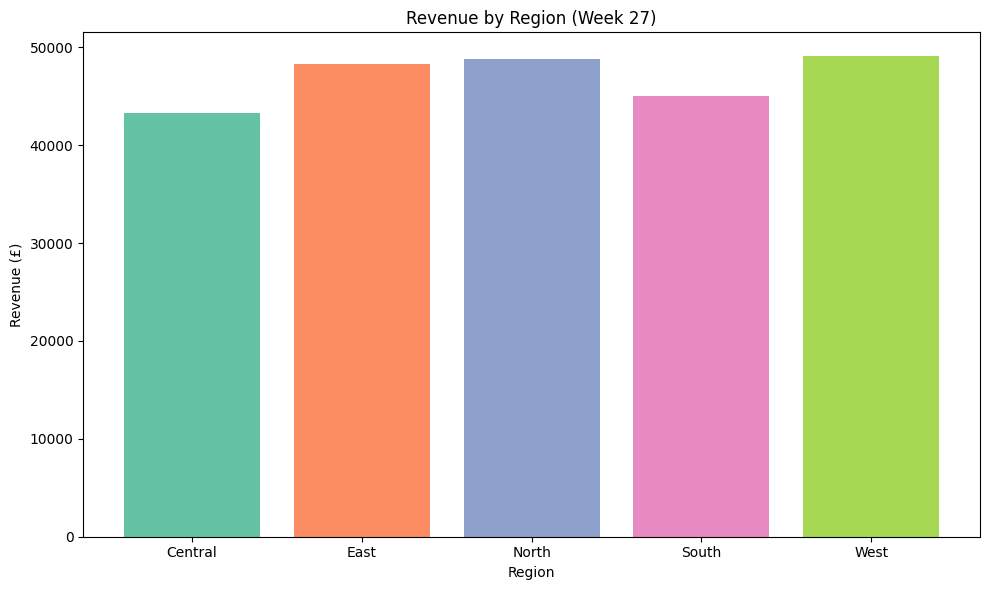

In [223]:
#1. Revenue by Region - Bar Chart

# The dataset only includes sales from a single week (Week 27: July 6, 2025),
#so we cannot generate a meaningful weekly trend line.
#Instead, we visualize revenue distribution across regions using a bar chart.

# Transpose weekly revenue data and exclude the 'Nan' region for plotting
data_to_plot = weekly_revenue_pivot.T
data_to_plot_clean = data_to_plot[~data_to_plot.index.isin(['Nan'])].reset_index(names='region')

# Extract regions andcorresponding revenue values
regions = data_to_plot_clean['region']
revenues = np.array(data_to_plot_clean.iloc[:, 1].values)

# Assign a unique pastel color to each region
colors = sns.color_palette("Set2", n_colors=len(regions))

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(regions, revenues, color=colors)
plt.title("Revenue by Region (Week 27)")
plt.ylabel("Revenue (£)")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

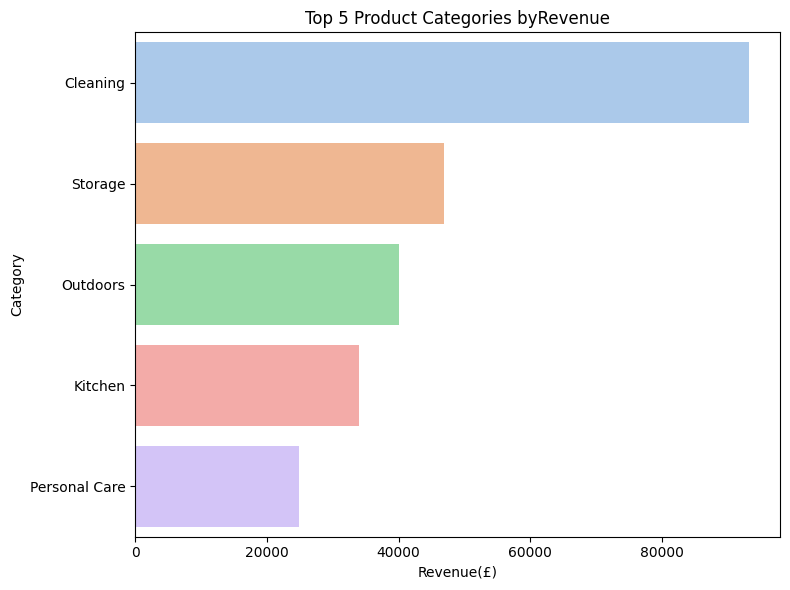

In [224]:
# 2. Bar chart ofthe top 5 categories based on total revenue
top5_categories = product_perf.sort_values('revenue', ascending=False).head(5)
plt.figure(figsize=(8, 6))
sns.barplot(data=top5_categories, x='revenue', y='category', hue='category', dodge=False, legend=False, palette='pastel')
plt.title("Top 5 Product Categories byRevenue")
plt.xlabel("Revenue(£)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

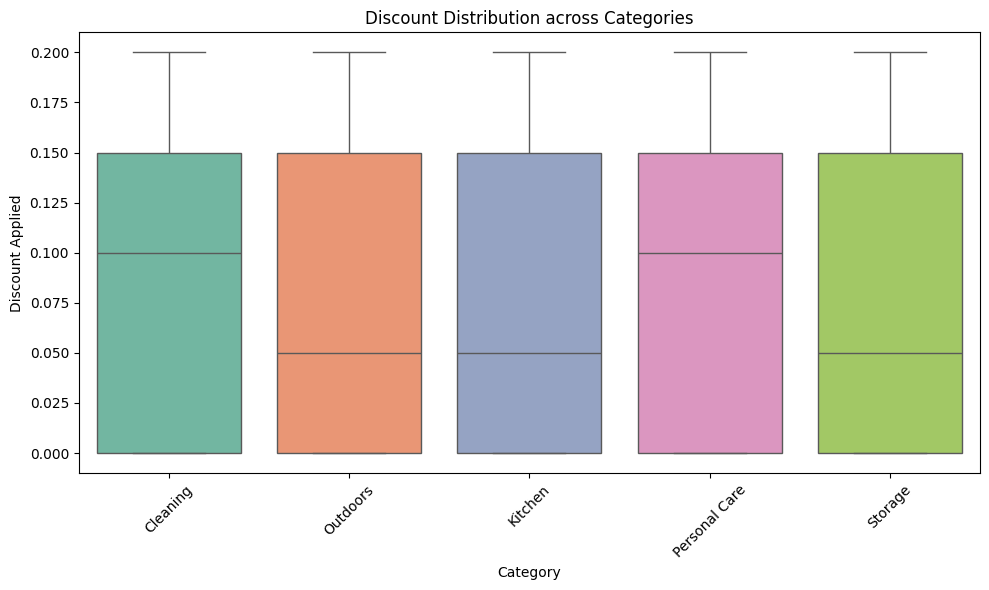

In [225]:
# 3. Boxplot showing the distributionof discounts by product category
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='category', y='discount_applied', hue='category', palette='Set2', legend=False)
plt.title("Discount Distribution across Categories")
plt.xlabel("Category")
plt.ylabel("Discount Applied")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

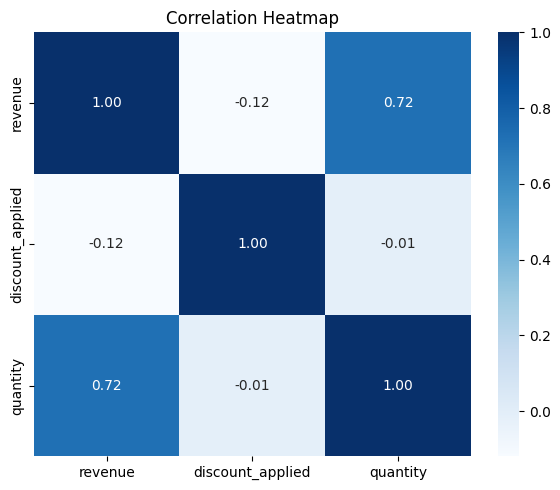

In [226]:
# 4. Heatmap showing correlations between revenue, quantity, and discount
corr_data = merged_df[['revenue', 'discount_applied', 'quantity']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_data, annot=True, cmap='Blues', fmt=".2f")  # Softer palette
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

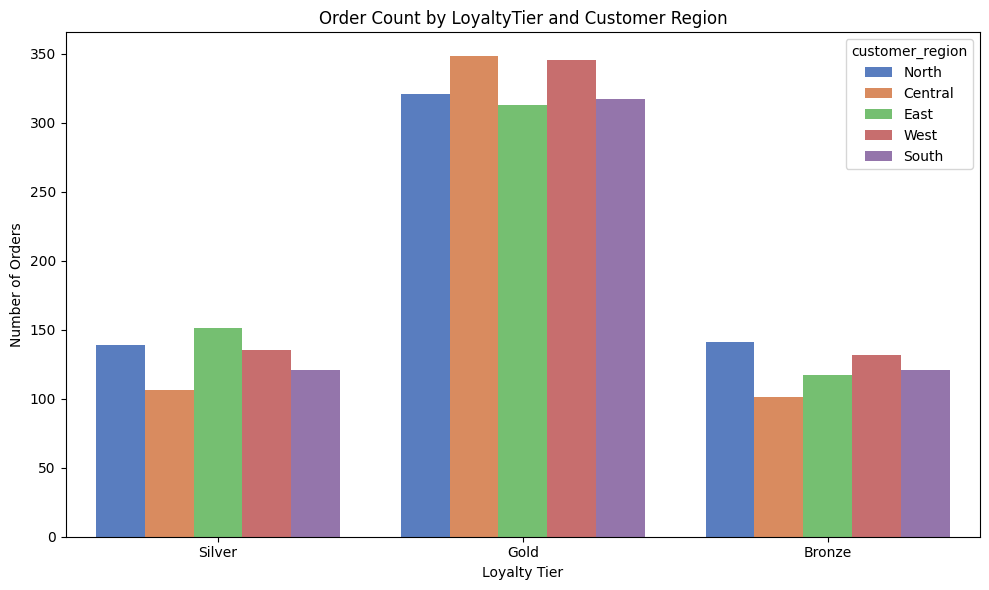

In [228]:
# 5. Countplot showing order volume by loyalty tierand customer region (excluding 'Unknown' and 'Nan' for display)

#Filter out unwanted values for display only
plot_data = merged_df[
    (~merged_df['loyalty_tier'].isin(['Unknown', 'Nan'])) &
    (~merged_df['customer_region'].isin(['Unknown', 'Nan']))
]
plt.figure(figsize=(10, 6))
sns.countplot(data=plot_data, x='loyalty_tier', hue='customer_region', palette='muted')
plt.title("Order Count by LoyaltyTier and Customer Region")
plt.xlabel("Loyalty Tier")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

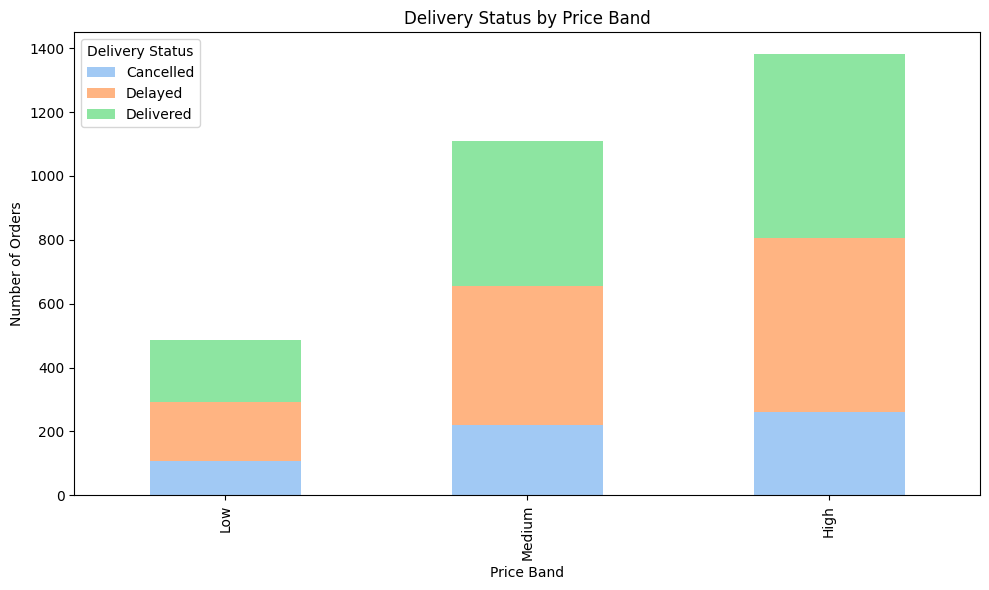

In [229]:
# 6.Stacked bar chart showing delivery status across price bands (excluding 'Nanfor display)

colors = sns.color_palette("pastel")

# Generate the grouped data
delivery_counts = merged_df.groupby(['price_band', 'delivery_status'], observed=False).size().unstack(fill_value=0)

# Remove 'Nan' index or columns just for display
delivery_counts = delivery_counts[~delivery_counts.index.isin(['Nan'])]
delivery_counts = delivery_counts.loc[:, ~delivery_counts.columns.isin(['Nan'])]

# Plot the stacked bar chart
delivery_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors[:len(delivery_counts.columns)]
)

plt.title("Delivery Status by Price Band")
plt.xlabel("Price Band")
plt.ylabel("Number of Orders")
plt.legend(title="Delivery Status")
plt.tight_layout()
plt.show()

## 7. Business Questions to Answer

### 7.1  Which product categories generate the most revenue, and in which regions?

,category,customer_region,revenue
1,Cleaning,East,20005.6705
3,Cleaning,North,19693.1075
5,Cleaning,West,19590.5155
4,Cleaning,South,16183.3955
0,Cleaning,Central,15631.6160
28,Storage,West,10062.7855
23,Storage,Central,9797.5680
27,Storage,South,9486.6965
16,Outdoors,West,8981.4465
14,Outdoors,North,8923.7850


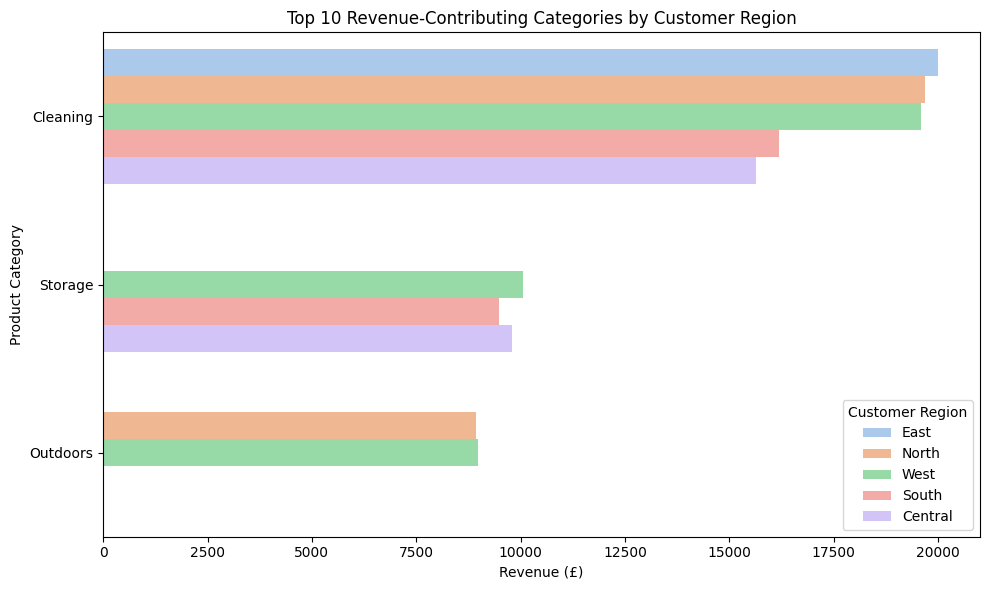

In [230]:
# Group by product category and customer region, then sum revenue
category_region_revenue = (
    merged_df.groupby(['category', 'customer_region'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
)

#Get the top 10 category-region combinations by revenue
top10_category_region = category_region_revenue.head(10)

# Show the top combinations ina table
display(top10_category_region)

#Bar chart for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_category_region, x='revenue', y='category', hue='customer_region', palette='pastel')
plt.title("Top 10 Revenue-Contributing Categories by Customer Region")
plt.xlabel("Revenue (£)")
plt.ylabel("Product Category")
plt.legend(title="Customer Region")
plt.tight_layout()
plt.show()

### 7.2  Do discounts lead to more items sold?

,has_discount,quantity
0,No Discount,2967.0
1,Discount,5977.0


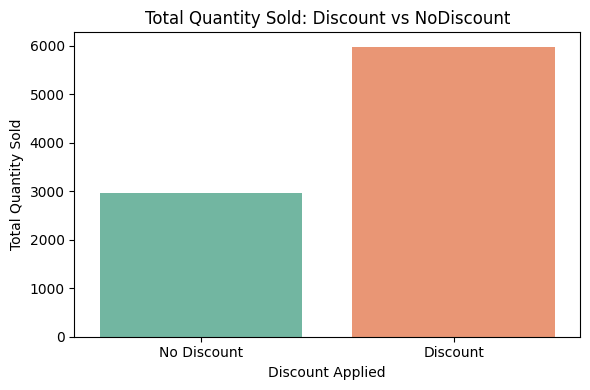

In [245]:
# Create a binary column: True if discount applied, False otherwise
merged_df['has_discount'] = merged_df['discount_applied'] > 0

# Group by discount presence and sum quantitiessold
discount_summary = merged_df.groupby('has_discount')['quantity'].sum().reset_index()
discount_summary['has_discount'] = discount_summary['has_discount'].map({True: 'Discount', False: 'No Discount'})

#Display summary table
display(discount_summary)

#Bar plot to visualize
plt.figure(figsize=(6, 4))
sns.barplot(data=discount_summary, x='has_discount', y='quantity', hue='has_discount', palette='Set2', legend=False)
plt.title("Total Quantity Sold: Discount vs NoDiscount")
plt.xlabel("Discount Applied")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

### 7.3  Which loyalty tier generates the most value?

,loyalty_tier,revenue
1,Gold,134780.5105
2,Silver,52032.6080
0,Bronze,47896.5050


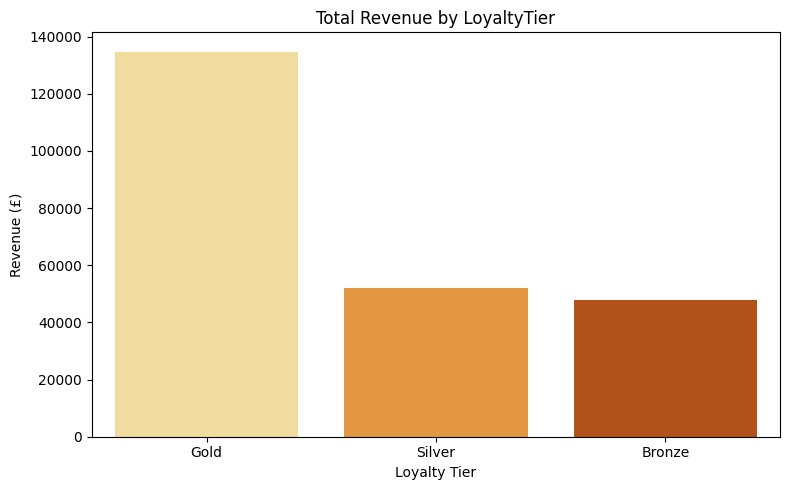

In [ ]:
# Group by loyalty tier and calculate total revenue
tier_revenue = (
    merged_df.groupby('loyalty_tier')['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
)

#Filter out 'Unknown' fordisplay only
filtered_table = tier_revenue[tier_revenue['loyalty_tier'] != 'Unknown']

# Display the filtered table
display(filtered_table)

#Usea warm colors palette for the bar chart
warm_colors = sns.color_palette("YlOrBr", n_colors=len(plot_data))

#Barchart comparingtotal revenue byloyalty tier (excluding 'Unknown')
plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_data,
    x='loyalty_tier',
    y='revenue',
    hue='loyalty_tier',
    palette=warm_colors,
    legend=False 
)
plt.title("Total Revenue by LoyaltyTier")
plt.xlabel("Loyalty Tier")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.show()


### 7.4  Are certain regions strugglingwith delivery delays?

,customer_region,is_late
4,West,0.410131
0,Central,0.407207
3,South,0.404293
2,North,0.392679
1,East,0.352542


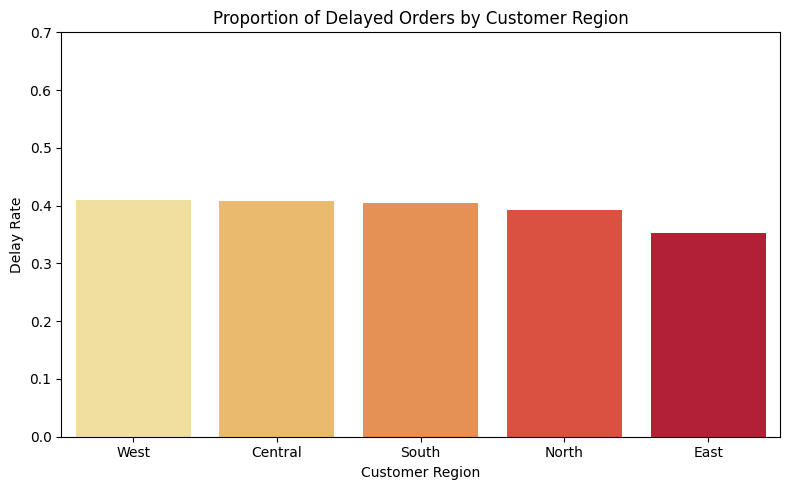

In [240]:
# Filter out missing or placeholder values in 'customer_region'
filtered_df = merged_df[
    merged_df['customer_region'].notna() & 
    (merged_df['customer_region'].str.lower() != 'nan')
]

# Group by customer regionand calculate delay rate
region_delay = (
    filtered_df.groupby('customer_region', observed=False)['is_late']
    .mean()
    .reset_index()
    .sort_values(by='is_late', ascending=False)
)
# Display the table of delay rates
display(region_delay)

#Bar chart: Delay rate bycustomer region 
plt.figure(figsize=(8, 5))
sns.barplot(
    data=region_delay,
    x='customer_region',
    y='is_late',
    hue='customer_region',     
    palette='YlOrRd',
    legend=False               
)
plt.title("Proportion of Delayed Orders by Customer Region")
plt.xlabel("Customer Region")
plt.ylabel("Delay Rate")
plt.ylim(0, 0.7)
plt.tight_layout()
plt.show()

### 7.5  Do customer signup patterns influence purchasing activity?

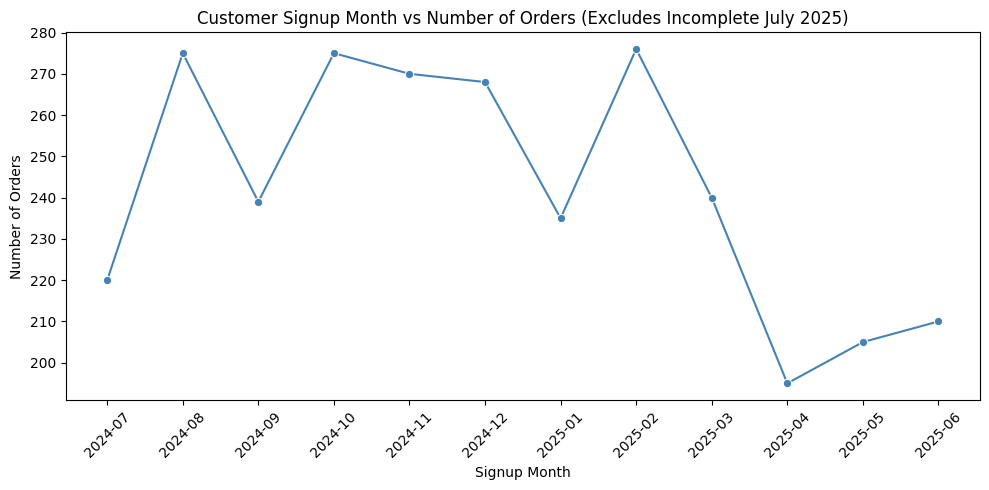

In [248]:
#Group by signup month and aggregate orders and revenue
signup_activity = (
    merged_df.groupby('signup_month')
    .agg(num_orders=('order_id', 'count'), revenue=('revenue', 'sum'))
    .reset_index()
)

# Convert Period to string for plotting
signup_activity['signup_month_str'] = signup_activity['signup_month'].astype(str)

#ExcludeJuly 2025 from visualisation since data is incomplete for that month
signup_activity_filtered = signup_activity[signup_activity['signup_month_str'] != '2025-07']

# Line plot: Orders over signup month
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=signup_activity_filtered,
    x='signup_month_str',
    y='num_orders',
    marker='o',
    color='steelblue'
)
plt.title("Customer Signup Month vs Number of Orders (Excludes Incomplete July 2025)")
plt.xlabel("Signup Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()